## Setup Environment

In [ ]:
# Install pkg for kmeans algo
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import string
import random
import time
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import regexp_tokenize

from nltk.corpus import gutenberg, stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA, TruncatedSVD
from mlxtend.preprocessing import DenseTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler

from kneed import KneeLocator
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, cohen_kappa_score, adjusted_rand_score
from sklearn.manifold import TSNE

from scipy.sparse import isspmatrix

from sklearn.mixture import GaussianMixture

from gensim.models.coherencemodel import CoherenceModel

### Download Texts from NLTK

In [ ]:
# Download text and related data from NLTK
nltk.download('punkt')
nltk.download('gutenberg')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Setup Globals

In [ ]:
# Set Globals
stop_words = set(stopwords.words('english'))

In [ ]:
# Randomize random seed
random.seed(time.time())

## Preprocessing

In [ ]:
def clean(text, label):
    #remove numbers from the text
    clean_text = re.sub('[^a-zA-Z]',' ', text )
    
    #Tokenizing data
    token_pattern = r'''(?x) (?:[A-Z]\.)+ | \w+(?:[-]\w+)* | \$?\d+(?:\.\d+)?%?| \.\.\. | [][.,;"'?():-_`]'''
    tokenized = regexp_tokenize(clean_text, token_pattern)
    #tokenized = nltk.word_tokenize(clean_text)

    #Removing stopwords
    tokenized_without_stopwords = [w for w in tokenized if not w in stop_words]
    
    #Convert to stem
    stemmer = SnowballStemmer("english")
    base_words = [stemmer.stem(word) for word in tokenized_without_stopwords]

      ## Lemmatisation (convert the word into root word)
    lemmatizer = WordNetLemmatizer()
    lemmitized_words = [lemmatizer.lemmatize(word) for word in base_words]

    #Creating 200 documents from each book. 
    #Each document contains 150 words    
    doc = []
    doc_words = []

    for i in range(0,200):
        data = random.sample(lemmitized_words, 150)
        doc_words.append(data)
        doc.append(' '.join(str(''.join(str(x) for x in v)) for v in data))

    # Adding labels to each text of 200 document
    df = pd.DataFrame()
    df['booktext_words'] = doc_words
    df['booktext'] = doc    
    df['authors'] = label

    return df

In [ ]:
files = gutenberg.fileids()
selected_titles = ['austen-persuasion.txt','bible-kjv.txt','bryant-stories.txt','carroll-alice.txt','chesterton-thursday.txt']
label_titles = list(string.ascii_lowercase[0:len(selected_titles)])

# Load Texts
texts = [nltk.corpus.gutenberg.open(title).read() for title in selected_titles]

# Clean and Process into dfs
processed_texts_dfs = [clean(text,label) for (text,label) in zip(texts, label_titles)]

## Organize Dataset

In [ ]:
# Combining all dataframe into one.
datasetdf = pd.concat(processed_texts_dfs,ignore_index = True)

In [ ]:
datasetdf

,booktext_words,booktext,authors
0,"[frederick, moment, honour, make, sensibl, bri...",frederick moment honour make sensibl bring tol...,a
1,"[head, step, delight, ladi, outweigh, harp, co...",head step delight ladi outweigh harp consid fo...,a
2,"[the, i, well, moreov, eager, i, sever, wors, ...",the i well moreov eager i sever wors take cont...,a
3,"[th, bent, first, afterward, place, usual, sai...",th bent first afterward place usual said i hom...,a
4,"[answer, great, there, never, er, sand, notion...",answer great there never er sand notion feel l...,a
...,...,...,...
995,"[french, must, prevent, question, doubt, impre...",french must prevent question doubt impress and...,e
996,"[ten, road, enemi, sudden, crowd, bull, motto,...",ten road enemi sudden crowd bull motto clamour...,e
997,"[never, even, dress, made, hous, paus, side, s...",never even dress made hous paus side said like...,e
998,"[care, whole, walk, mutter, nerv, fire, nose, ...",care whole walk mutter nerv fire nose ask acci...,e


In [ ]:
# Label classes
labelencoder = LabelEncoder()

datasetdf['target'] = labelencoder.fit_transform(datasetdf['authors'])
X = datasetdf["booktext"]
X_word = datasetdf["booktext_words"]
Y = datasetdf['target']

In [ ]:
datasetdf

,booktext_words,booktext,authors,target
0,"[frederick, moment, honour, make, sensibl, bri...",frederick moment honour make sensibl bring tol...,a,0
1,"[head, step, delight, ladi, outweigh, harp, co...",head step delight ladi outweigh harp consid fo...,a,0
2,"[the, i, well, moreov, eager, i, sever, wors, ...",the i well moreov eager i sever wors take cont...,a,0
3,"[th, bent, first, afterward, place, usual, sai...",th bent first afterward place usual said i hom...,a,0
4,"[answer, great, there, never, er, sand, notion...",answer great there never er sand notion feel l...,a,0
...,...,...,...,...
995,"[french, must, prevent, question, doubt, impre...",french must prevent question doubt impress and...,e,4
996,"[ten, road, enemi, sudden, crowd, bull, motto,...",ten road enemi sudden crowd bull motto clamour...,e,4
997,"[never, even, dress, made, hous, paus, side, s...",never even dress made hous paus side said like...,e,4
998,"[care, whole, walk, mutter, nerv, fire, nose, ...",care whole walk mutter nerv fire nose ask acci...,e,4


## Feature Engineering - BOW, TF-IDF, LDA

In [ ]:
# Primary Transformations
primary_transformers = [
  { "model": CountVectorizer(), "name": "BOW" }, # BOW Model
  { "model": TfidfVectorizer(), "name": "TF-IDF" }, #TF-IDF Model
]

primary_transforms = [
    {
        "data": transformer["model"].fit_transform(X),
        "model_name": transformer["name"]
    } for transformer in primary_transformers
]

In [ ]:
# Secondard Transformations (Using BOW as base)
secondary_transformers = [
  { "model": LatentDirichletAllocation(), "name": "LDA(BOW)" }, #LDA Model
]

secondary_transforms = [
    {
        "data": transformer["model"].fit_transform(primary_transforms[0]["data"]), # Use BOW data for the secondary input
        "model_name": transformer["name"]
    } for transformer in secondary_transformers
]

In [ ]:
all_transforms = primary_transforms + secondary_transforms
all_transformers = primary_transformers + secondary_transformers
all_transformer_names = [t['name'] for t in all_transformers]

## Clustering - K-Means, Agglomerative (hierarchical), EM

### Clustering Utils

In [ ]:
# Clustering Utils (Working on this rn)
def kappa(targets, model_names, predicted_labels_by_model, cluster_algo_name):
  for (model_name, labels) in zip(model_names, predicted_labels_by_model):
      kappa = cohen_kappa_score(targets, labels)

      print(f'Cohen Kappa Score between truth and {cluster_algo_name} on {model_name} transformed data is {kappa}')


def silhouette(transformes, labels):
  for (transform, label) in zip(transformes, labels):
    score = silhouette_score(transform["data"], label, metric='euclidean')

    print(f'KMeans ({transform["model_name"]}) original Data Silhouette Score: {score}')

def ARS(targets, model_names, predicted_labels_by_model, cluster_algo_name):
  for (model_name, labels) in zip(model_names, predicted_labels_by_model):
      ars = adjusted_rand_score(targets, labels)

      print(f'Adjusted Rand Score between truth and {cluster_algo_name} on {model_name} transformed data is {ars}')


def get_top_features_cluster(data, prediction, transformer, n_features):
    labels = np.unique(prediction)
    dfs = []
    
    for label in labels:
        id_temp = np.where(prediction==label)
        x_means = np.mean(data[id_temp], axis = 0)
        sorted_means = np.argsort(x_means)[::-1][:n_features]
        features = transformer.get_feature_names_out()

        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        
        dfs.append(df)
    
    return dfs


def plotWords(dfs, transformer_name, n_features):
    for i in range(0, len(dfs)):
        plt.title((f"Most Common Words in Cluster {i} for {transformer_name} transformer"), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_features])
        plt.show()

def plotTopNWords(transforms, predictions, n):
  for idx, transform in enumerate(transforms, start=0):
    if idx > 1:
      ## Dont run this for LDA model
      break

    d = transform['data']

    if isspmatrix(d):
      d = d.toarray()

    top10df = get_top_features_cluster(d, predictions[idx], all_transformers[idx]['model'], n)
    plotWords(top10df, all_transformer_names[idx], n)
    print('\n' * 2)


### K-Means Algo

In [ ]:
def kmeans_elbow(data, model_name):
    number_of_clusters = 12
    wcss = []

    for i in range (1, number_of_clusters):
      model = KMeans(n_clusters=i, 
                    init='k-means++', 
                    max_iter=100, # Maximum number of iterations of the k-means algorithm for a single run.
                    n_init=1,
                    random_state = 0)  # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
      model.fit(data)
      wcss.append(model.inertia_)
    
    knee = KneeLocator(range(1, number_of_clusters), wcss, curve="convex", direction="decreasing")

    plt.plot(range(1, number_of_clusters), wcss)
    plt.title(model_name)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(data)
    
    plt.show()

    print(f'Knee located at {knee.elbow} clusters')

    return knee.elbow
    
def kmeans(data, model_name, n_clusters=5):
  kmeans_kwargs = {
      "init": "k-means++",
      "n_init": 10,
      "max_iter": 300,
      "random_state": 0
  }

  model = KMeans(n_clusters, **kmeans_kwargs )
  
  model.fit(data)

  labels = model.labels_

  prediction=model.predict(data)
  
  return model, prediction, labels

#### Standard K-Means with Elbow test

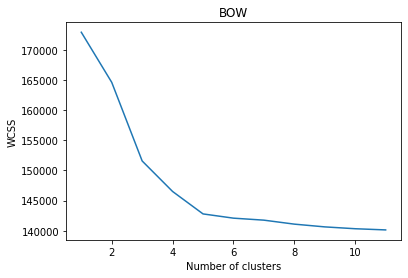

Knee located at 5 clusters


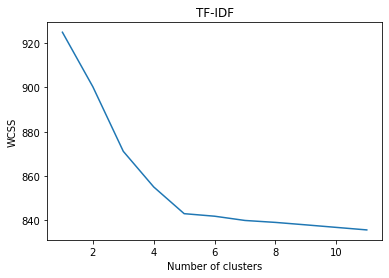

Knee located at 5 clusters


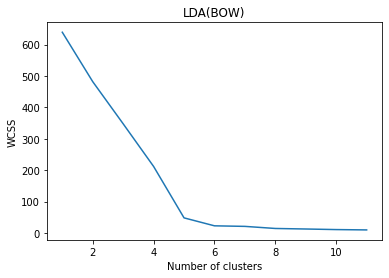

Knee located at 5 clusters


In [ ]:
# Use Kmeans to determine optimal clusters per model
for transform in all_transforms:
  kmeans_elbow(transform["data"], transform["model_name"])

  As seen in the graphs, the optimal amount of clusters is five. This naturally matches the number of texts and authors selected. This also holds true for all feature models.


#### Standard K-Means using the cluster count determined by the elbow test

In [ ]:
# Use KMeans to cluster based on each models transformed data (5 clusters)
std_kmeans_by_model = [kmeans(transform["data"], transform["model_name"], 5) for transform in all_transforms]
std_kmeans_predictions_by_model = [data[1] for data in std_kmeans_by_model]

##### Evaluation

In [ ]:
silhouette(all_transforms, std_kmeans_predictions_by_model)

KMeans (BOW) original Data Silhouette Score: 0.07620759763265783
KMeans (TF-IDF) original Data Silhouette Score: 0.0455194015648751
KMeans (LDA(BOW)) original Data Silhouette Score: 0.8260264307391754


In [ ]:
kappa(Y, all_transformer_names, std_kmeans_predictions_by_model, "K-Means")

Cohen Kappa Score between truth and K-Means on BOW transformed data is -0.24875000000000003
Cohen Kappa Score between truth and K-Means on TF-IDF transformed data is 0.0
Cohen Kappa Score between truth and K-Means on LDA(BOW) transformed data is 0.0


In [ ]:
ARS(Y, all_transformer_names, std_kmeans_predictions_by_model, "K-Means")

Adjusted Rand Score between truth and K-Means on BOW transformed data is 0.9924950630770626
Adjusted Rand Score between truth and K-Means on TF-IDF transformed data is 1.0
Adjusted Rand Score between truth and K-Means on LDA(BOW) transformed data is 1.0


#### Standard K-Means using scaled features


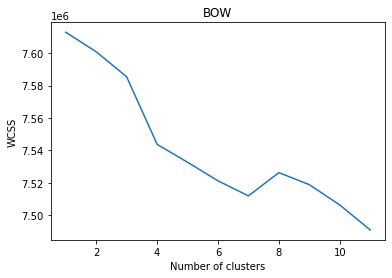

Knee located at 4 clusters


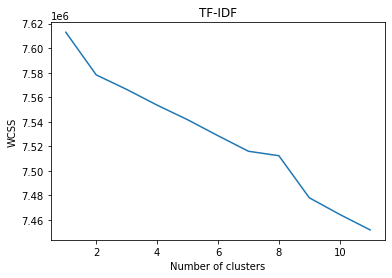

Knee located at 2 clusters


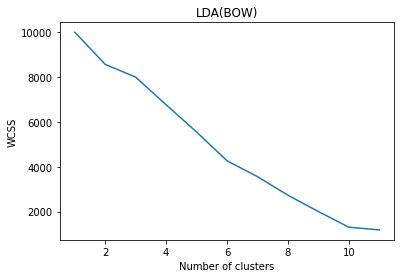

Knee located at 6 clusters


In [ ]:
scaler = StandardScaler(with_mean=False)

scaled_transforms = [{ "data": scaler.fit_transform(transform["data"]), "model_name": transform["model_name"]} for transform in all_transforms]

scaled_n_clusters = [kmeans_elbow(transform["data"], transform["model_name"]) for transform in scaled_transforms]

std_scaled_kmeans_by_model = [kmeans(transform["data"], transform["model_name"], n) for (n, transform) in zip(scaled_n_clusters, scaled_transforms)]
std_scaled_kmeans_predictions_by_model = [data[1] for data in std_scaled_kmeans_by_model]

Scaling using this technique doesnt prove to increase the clustering abilities. This is most likely due to the nature of the data itself where scaling isnt as effective

##### Evaluation

In [ ]:
# Note, this occasionally fails due to to few samples
# silhouette(all_transforms, std_scaled_kmeans_predictions_by_model)

In [ ]:
kappa(Y, all_transformer_names, std_scaled_kmeans_predictions_by_model, "K-Means")

Cohen Kappa Score between truth and K-Means on BOW transformed data is -0.2500000000000002
Cohen Kappa Score between truth and K-Means on TF-IDF transformed data is 0.0
Cohen Kappa Score between truth and K-Means on LDA(BOW) transformed data is 0.29761904761904767


In [ ]:
ARS(Y, all_transformer_names, std_scaled_kmeans_predictions_by_model, "K-Means")

Adjusted Rand Score between truth and K-Means on BOW transformed data is 0.2099985432765661
Adjusted Rand Score between truth and K-Means on TF-IDF transformed data is 0.20986026891642498
Adjusted Rand Score between truth and K-Means on LDA(BOW) transformed data is 0.9841654925461283


#### Standard K-Means using SVD dimensional reduction

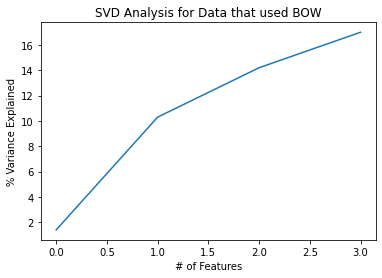

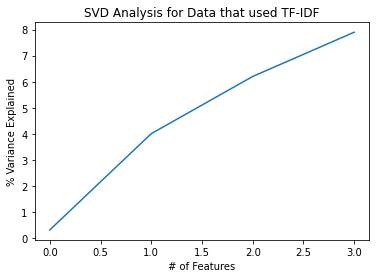

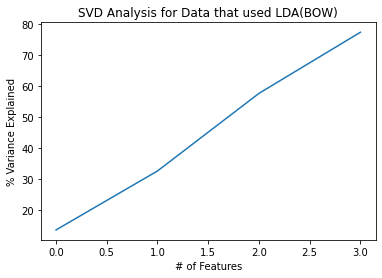

In [ ]:
# n_components=4 to view the optimal features number

svd_fitted_data = [{ "data": TruncatedSVD(4).fit(transform["data"]), "model_name": transform["model_name"]} for transform in all_transforms]

for transform in svd_fitted_data:
  variance = transform['data'].explained_variance_ratio_

  plt.ylabel('% Variance Explained')
  plt.xlabel('# of Features')
  plt.title(f"SVD Analysis for Data that used {transform['model_name']}")
  plt.plot(np.cumsum(np.round(variance, 3)*100))
  plt.show()


The features outlined by the reduction mechanism make sense, since we are only looking at one feature

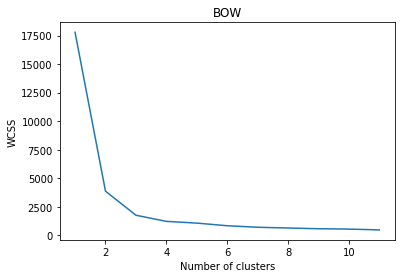

Knee located at 3 clusters


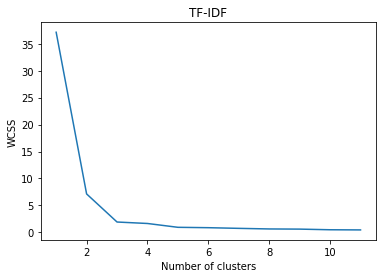

Knee located at 3 clusters


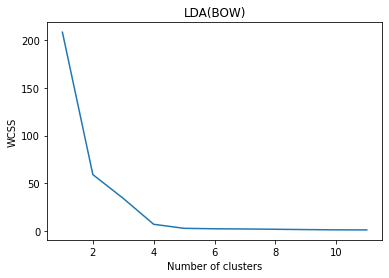

Knee located at 4 clusters


In [ ]:
svd_transforms = [{ "data": TruncatedSVD(2).fit_transform(transform["data"]), "model_name": transform["model_name"]} for transform in all_transforms]

svd_n_clusters = [kmeans_elbow(transform["data"], transform["model_name"]) for transform in svd_transforms]

std_svd_kmeans_by_model = [kmeans(transform["data"], transform["model_name"], n) for (n, transform) in zip(svd_n_clusters, svd_transforms)]
std_svd_kmeans_predictions_by_model = [data[1] for data in std_svd_kmeans_by_model]

Here, the feature reduction to 2 has resulted in 3 clusters

##### Evaluation

In [ ]:
silhouette(all_transforms, std_svd_kmeans_predictions_by_model)

KMeans (BOW) original Data Silhouette Score: 0.06354249232760638
KMeans (TF-IDF) original Data Silhouette Score: 0.0338387729667196
KMeans (LDA(BOW)) original Data Silhouette Score: 0.6870325316327102


In [ ]:
kappa(Y, all_transformer_names, std_svd_kmeans_predictions_by_model, "K-Means")

Cohen Kappa Score between truth and K-Means on BOW transformed data is 0.125
Cohen Kappa Score between truth and K-Means on TF-IDF transformed data is 0.25
Cohen Kappa Score between truth and K-Means on LDA(BOW) transformed data is -0.00374999999999992


In [ ]:
ARS(Y, all_transformer_names, std_svd_kmeans_predictions_by_model, "K-Means")

Adjusted Rand Score between truth and K-Means on BOW transformed data is 0.45536415858185897
Adjusted Rand Score between truth and K-Means on TF-IDF transformed data is 0.4788491996543062
Adjusted Rand Score between truth and K-Means on LDA(BOW) transformed data is 0.7782734978278049


#### Standard K-Means using TSNE dimensional reduction

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

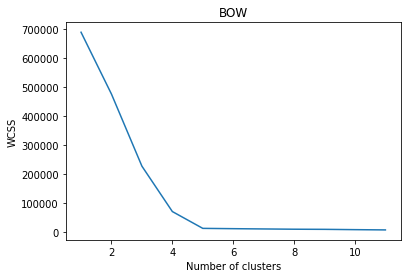

Knee located at 4 clusters


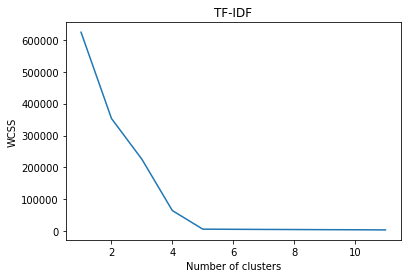

Knee located at 4 clusters


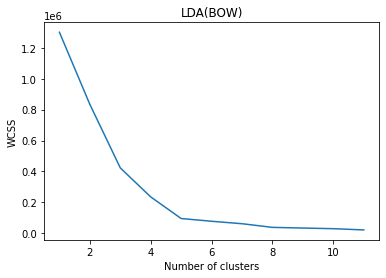

Knee located at 5 clusters


In [ ]:
tsne_transforms = [{ "data": TSNE(2).fit_transform(transform["data"]), "model_name": transform["model_name"]} for transform in all_transforms]

tsne_n_clusters = [kmeans_elbow(transform["data"], transform["model_name"]) for transform in tsne_transforms]

std_tsne_kmeans_by_model = [kmeans(transform["data"], transform["model_name"], n) for (n, transform) in zip(tsne_n_clusters, tsne_transforms)]
std_tsne_kmeans_predictions_by_model = [data[1] for data in std_tsne_kmeans_by_model]

Interestingly, in this case, though the knees report generally 5 clusters, the BOW model reports the upper knee at 4

##### Evaluation

In [ ]:
silhouette(all_transforms, std_tsne_kmeans_predictions_by_model)

In [ ]:
kappa(Y, all_transformer_names, std_tsne_kmeans_predictions_by_model, "K-Means")

In [ ]:
ARS(Y, all_transformer_names, std_tsne_kmeans_predictions_by_model, "K-Means")

#### Top 10 Features (using standard K-Means)


In [ ]:
plotTopNWords(all_transforms, std_kmeans_predictions_by_model, 10)

#### Top 5 Features (using std K-Means)

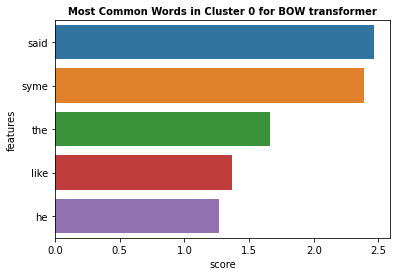

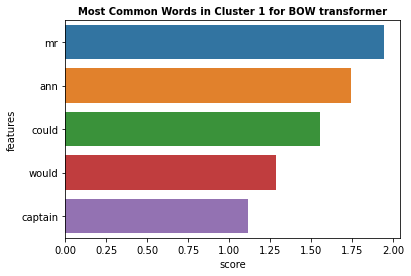

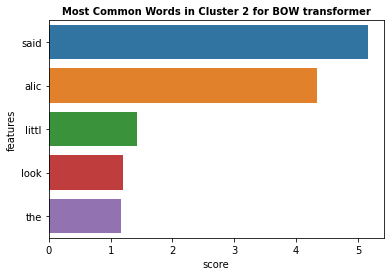

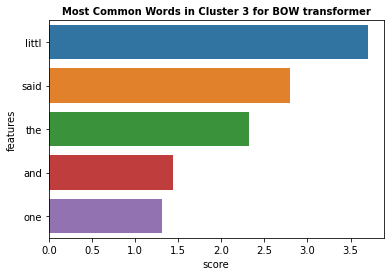

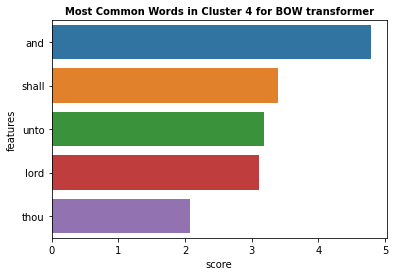

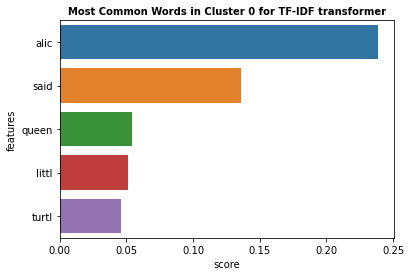

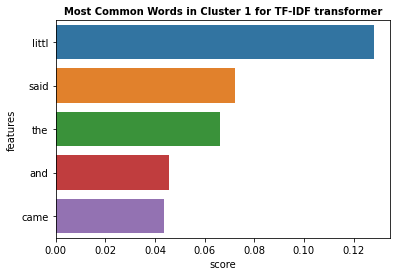

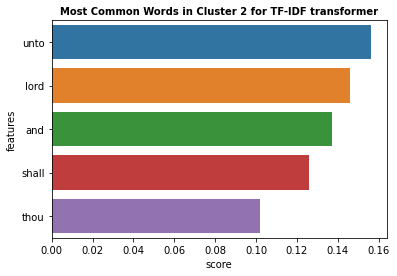

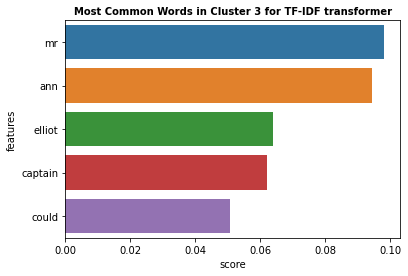

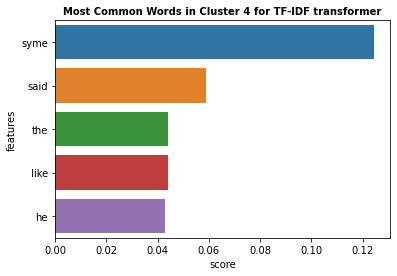

In [ ]:
plotTopNWords(all_transforms,std_kmeans_predictions_by_model, 5)

### Hierarchical Algos

##### Dendrogram

In [ ]:
def dendrogram_algo(data, model_name, linkage_method):
  plt.figure()
  plt.title(f'Visualising {model_name} data')

  df = pd.DataFrame(data)

  linked = linkage(df, linkage_method)

  print(linked.shape)

  dend = dendrogram(linked)

  plt.show()

  return dend

Using **WARD** linkage *(std data)*


In [ ]:
for idx, transform in enumerate(all_transforms, start=0):
  d = transform['data']

  if isspmatrix(d):
    d = d.toarray()

  dendrogram_algo(d,transform['model_name'],'ward')


Using **Single** Linkage *(std data)*

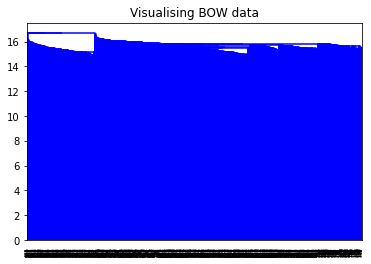

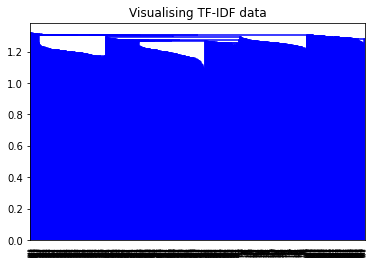

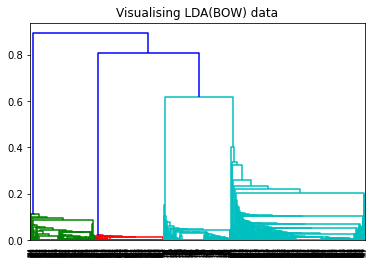

In [ ]:
for idx, transform in enumerate(all_transforms, start=0):
  d = transform['data']

  if isspmatrix(d):
    d = d.toarray()

  dendrogram_algo(d,transform['model_name'],'single')


Comparing the ward to single linkage algos, single does not segment the data in a useful manner

Using **Ward** Linkage *(tsne data)*

IndexError: ignored

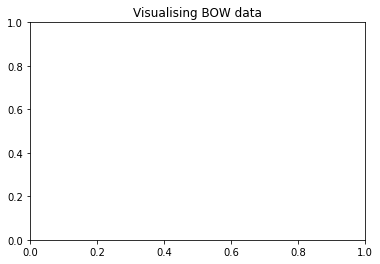

In [ ]:
for idx, transform in enumerate(tsne_transforms, start=0):
  dendrogram_algo(transform['data'],transform['model_name'],'ward')


#### Agglomerative *(std data)*

In [ ]:
# Clustering Algo 2 - Hierarchical 
def agglomerative(data, model_name, linkage_method):
  # convert data to dense format for this algo
  dense_data = DenseTransformer().fit_transform(data)
  model = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = linkage_method)

  return model.fit_predict(dense_data)

In [ ]:
agglomerative_std_predictions = [agglomerative(transform["data"], transform["model_name"], 'ward') for transform in all_transforms]

##### Evaluation

In [ ]:
# Check Sikhouette Scores for each models predictions
silhouette(all_transforms, agglomerative_std_predictions)

KMeans (BOW) original Data Silhouette Score: 0.07174287566285407
KMeans (TF-IDF) original Data Silhouette Score: 0.04148491078937516
KMeans (LDA(BOW)) original Data Silhouette Score: 0.6904336854608588


In [ ]:
kappa(Y, all_transformer_names, agglomerative_std_predictions, "Agglomerative")

Cohen Kappa Score between truth and Agglomerative on BOW transformed data is 0.0
Cohen Kappa Score between truth and Agglomerative on TF-IDF transformed data is 0.0
Cohen Kappa Score between truth and Agglomerative on LDA(BOW) transformed data is 0.25


In [ ]:
ARS(Y, all_transformer_names, agglomerative_std_predictions, "Agglomerative")

Adjusted Rand Score between truth and Agglomerative on BOW transformed data is 0.7819253438113949
Adjusted Rand Score between truth and Agglomerative on TF-IDF transformed data is 0.7819253438113949
Adjusted Rand Score between truth and Agglomerative on LDA(BOW) transformed data is 0.7819253438113949


#### Agglomerative *(tsne data)*

In [ ]:
agglomerative_tsne_predictions = [agglomerative(transform["data"], transform["model_name"], 'ward') for transform in tsne_transforms]

##### Evaluation

In [ ]:
silhouette(all_transforms, agglomerative_tsne_predictions)

KMeans (BOW) original Data Silhouette Score: 0.07174287566285407
KMeans (TF-IDF) original Data Silhouette Score: 0.04148491078937516
KMeans (LDA(BOW)) original Data Silhouette Score: 0.6718654610868214


In [ ]:
kappa(Y, all_transformer_names, agglomerative_tsne_predictions, "Agglomerative")

Cohen Kappa Score between truth and Agglomerative on BOW transformed data is 0.25
Cohen Kappa Score between truth and Agglomerative on TF-IDF transformed data is 0.0
Cohen Kappa Score between truth and Agglomerative on LDA(BOW) transformed data is 0.25


In [ ]:
ARS(Y, all_transformer_names, agglomerative_tsne_predictions, "Agglomerative")

Adjusted Rand Score between truth and Agglomerative on BOW transformed data is 0.7819253438113949
Adjusted Rand Score between truth and Agglomerative on TF-IDF transformed data is 0.7819253438113949
Adjusted Rand Score between truth and Agglomerative on LDA(BOW) transformed data is 0.7819253438113949


#### Top 10 Features *(using standard data)*

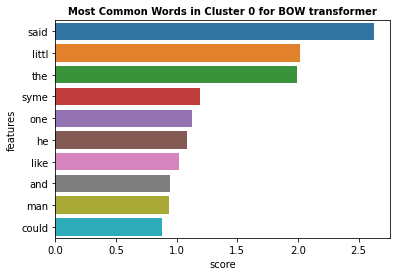

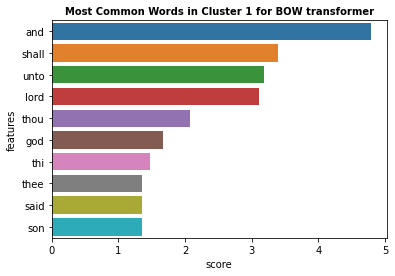

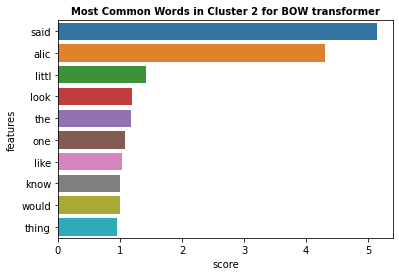

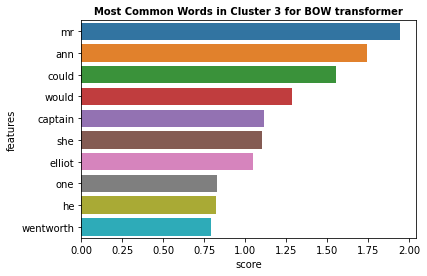

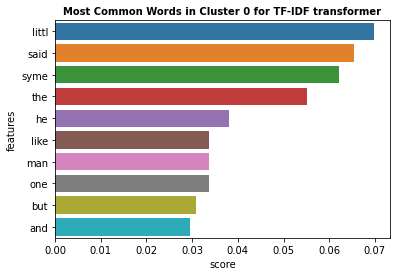

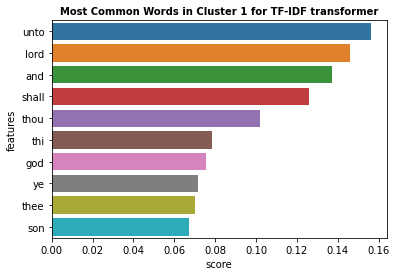

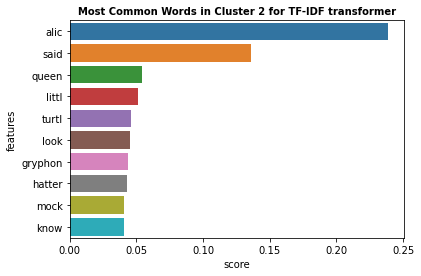

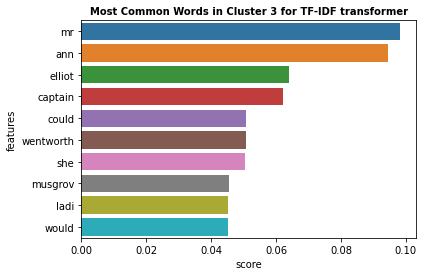

In [ ]:
plotTopNWords(all_transforms, agglomerative_std_predictions, 10)

#### Top 10 Features *(using tsne data)*

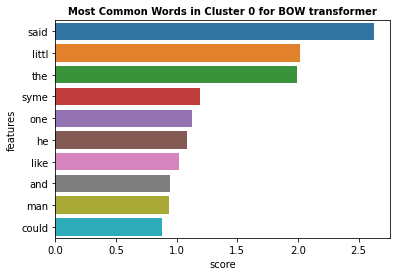

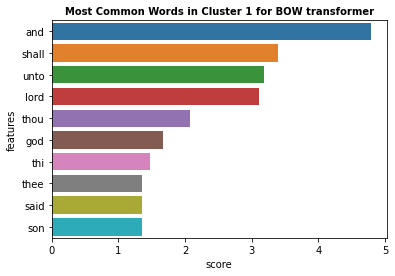

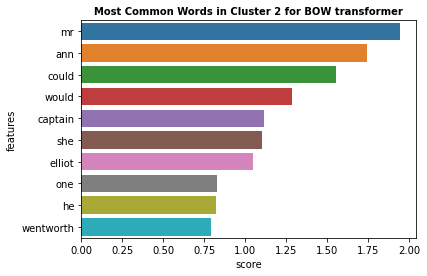

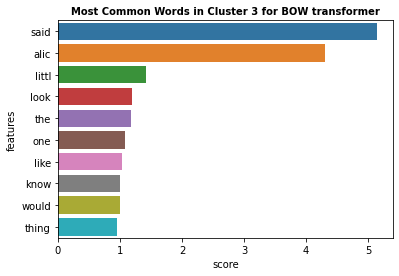

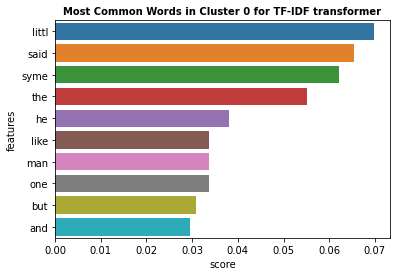

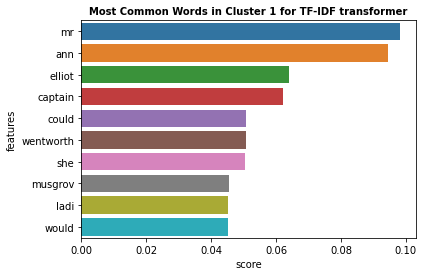

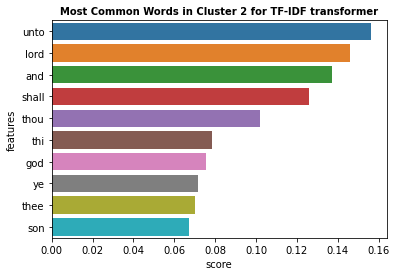

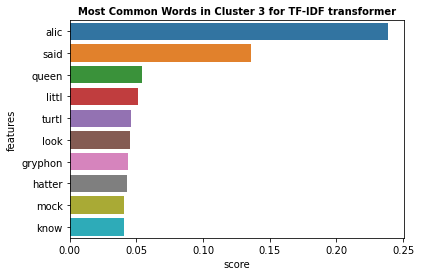

In [ ]:
plotTopNWords(all_transforms, agglomerative_tsne_predictions, 10)

### EM Algo

In [ ]:
def em_algo_chart(data,model_name):
    n_components = np.arange(1, 21)
    models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(data) for n in n_components]    
    
    plt.plot(n_components, [m.bic(data) for m in models], label='BIC')
    plt.plot(n_components, [m.aic(data) for m in models], label='AIC')

    plt.legend(loc='best')
    plt.xlabel('Num of Components')
    plt.title(model_name)
    plt.show()

def em_algo(data):
  model = GaussianMixture(n_components=5)

  d = data

  if isspmatrix(d):
    d = d.toarray()

  return model.fit_predict(d)

In [ ]:
for idx, transform in enumerate(tsne_transforms, start=0):
  d = transform['data']

  if isspmatrix(d):
    d = d.toarray()

  em_algo_chart(d, transform['model_name'])

#### *(standard data)*

In [ ]:
em_predictions = [em_algo(transform['data']) for transform in all_transforms]

##### Evaluation

In [ ]:
#EM Silhouette
silhouette(all_transforms, em_predictions)

In [ ]:
#EM Kappa
kappa(Y, all_transformer_names, em_predictions, "EM")

In [ ]:
#EM ARS
ARS(Y, all_transformer_names, em_predictions, "EM")

#### *(tsne data)*

In [ ]:
em_tsne_predictions = [em_algo(transform['data']) for transform in tsne_transforms]

##### Evaluation

In [ ]:
silhouette(all_transforms, em_tsne_predictions)

In [ ]:
kappa(Y, all_transformer_names, em_tsne_predictions, "EM")

In [ ]:
ARS(Y, all_transformer_names, em_tsne_predictions, "EM")

#### Top 10 Features *(using standard data)*

In [ ]:
plotTopNWords(all_transforms, em_predictions, 10)

#### Top 10 Features *(using tsne data)*

In [ ]:
plotTopNWords(all_transforms, em_tsne_predictions, 10)